In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.stats import poisson
from scipy.stats import bernoulli
from scipy.stats import gamma
from scipy.stats import halfnorm
from sklearn.neighbors import KernelDensity

### Functions

In [2]:
# Constants 

earth_radius_in_m = 6.378e6
sun_radius_in_m = 6.9566e8
rsol_in_au = 0.00465
print(1/rsol_in_au)
rearth_in_rsol = earth_radius_in_m/sun_radius_in_m

kepler_exp_time_internal = 6.019802903/(24.*60.*60.)
kepler_read_time_internal = 0.5189485261/(24.*60.*60.)
num_exposures_per_LC = 270.
LC_integration_time = kepler_exp_time_internal*num_exposures_per_LC
LC_read_time = kepler_read_time_internal*num_exposures_per_LC
LC_duration = LC_integration_time + LC_read_time
LC_rate = 1./LC_duration

215.05376344086022


In [3]:
def semimajor_axis_radius_ratio(P, M, R):
	'''
	This function calculates the semimajor axis (a) to stellar radius (R) ratio.

	Input:
		P: float, period in days
		M: float, stellar mass in solar masses
		R: float, stellar radius in solar radii
	
	Output:
		a/R: float, semimajor axis to stellar radius ratio	
	'''
	a3 = M*(P/365.)**2. #Calculate a^3 
	a = a3**(1./3.)
	return a/R/rsol_in_au

def transit_depth(Rp, R, u1, u2):

	'''
	This function calculates the transit depth.

	Input:
		Rp: float, planet radius in Earth radii
		R: float, stellar radius in solar radii
		u1: float, limb darkening parameter
		u2: float, limb darkening parameter

	Output:
		depth: float, transit depth
	'''
	k = Rp/R*rearth_in_rsol
	c0 = 1. - (u1 + u2)
	w = c0/4. + (u1 + 2.*u2)/6. - u2/8.
	return 1. - (c0/4. + (u1+2.*u2)*(1.-k**2.)**(3./2.)/6. - u2*(1.-k**2)/8.)/w

def transit_duration(P, aR, b):
		
	'''
	This function calculates the transit duration.

	Input:
		P: float, period in days
		aR: float, semimajor axis to stellar radius ratio
		b: float, impact parameter
	
	Output:
		Tdur: float, transit duration
	'''

	Tdur = 24.*(P/np.pi)/aR*np.sqrt(1.-b**2.)
	
	return Tdur

def impact_parameter(aR, i):

	'''
	This function calculates the impact parameter.

	Input:
		aR: float, semimajor axis to stellar radius ratio
		i: float, inclination in radians
	
	Output:
		b: float, impact parameter
	'''

	b = aR*np.cos(i)

	return b

def num_transits(P, Tobs, fduty):

	'''
	This function calculates the number of transits.

	Input:
		P: float, period in days
		Tobs: float, observation time in days
		fduty: float, duty cycle

	Output:
		Ntr: float, number of transits
	'''

	Ntr = np.round(Tobs/P*fduty)

	return Ntr

def transit_SNR(P, Rp, dur, R, u1, u2, Tobs, fduty, std):

	'''
	This function calculates the transit signal-to-noise ratio.

	Input:
		P: float, period in days
		Rp: float, planet radius in Earth radii
		dur: float, transit duration in hours
		R: float, stellar radius in solar radii
		u1: float, limb darkening parameter
		u2: float, limb darkening parameter
		Tobs: float, observation time in days
		fduty: float, duty cycle
		std: float, standard deviation of noise

	Output:
		SNR: float, signal-to-noise ratio
	'''

	Ntr = num_transits(P, Tobs, fduty)
	depth = transit_depth(Rp, R, u1, u2)

	SNR = depth/std*np.sqrt(Ntr*dur*LC_rate)

	return SNR

def P_win(P, Tobs, fduty):

	'''
	This function calculates the window function.

	Input:
		P: float, period in days
		Tobs: float, observation time in days
		fduty: float, duty cycle

	Output:
		Pwin: float
	'''

	j = Tobs/P
	Pwin = np.where(j < 2., 0.0, 1.-(1.-fduty)**j-j*fduty*(1.-fduty)**(j-1.)-0.5*j*(j-1.)*fduty*fduty*(1.-fduty)**(j-2.))
	return Pwin

def det_comp(SNR, A, B, C):
		
	'''
	This function calculates the detection completeness.

	Input:
		SNR: float, signal-to-noise ratio
		A: float, parameter
		B: float, parameter
		C: float, parameter
	
	Output:
		det_comp: float, detection completeness
		
	'''
	det_comp = C*gamma.cdf(SNR, A, scale=B)
	
	return det_comp

def P_det(Ntr, SNR):

	'''
	This function calculates the detection probability.

	Input:
		Ntr: float, number of transits
		SNR: float, signal-to-noise ratio

	Output:
		Pdet: float, detection probability
	'''

	Pdet = np.where(Ntr >= 37, det_comp(SNR,12.23315232,  0.78203581,  0.94645662), np.where(Ntr >= 19, 
						det_comp(SNR,14.86511928,  0.72917663,  0.91642721), np.where(Ntr >= 10, 
						det_comp(SNR,11.45382365,  1.07249528,  0.91176524), np.where(Ntr >= 7, 
						det_comp(SNR,11.54128644,  1.20628098,  0.88169029), np.where(Ntr == 6, 
						det_comp(SNR,11.48116478,  1.27632116,  0.83694848), np.where(Ntr == 5, 
						det_comp(SNR,13.54878807,  1.09003313,  0.7704247), np.where(Ntr == 4, 
						det_comp(SNR,17.47440559,  0.90589395,  0.66508744), np.where(Ntr == 3, 
						det_comp(SNR,12.02912833,  1.38916308,  0.46525859), 0.0))))))))

	return Pdet

def transit_noise_model(P, Rp, R, aR, b, Tobs, fduty, std):

	'''
	This function calculates the transit noise model.

	Input:
		P: float, period in days
		Rp: float, planet radius in Earth radii
		R: float, stellar radius in solar radii
		aR: float, semimajor axis to stellar radius ratio
		b: float, impact parameter
		Tobs: float, observation time in days
		fduty: float, duty cycle
		std: float, standard deviation of noise

	Output:
		noise_model: float, transit noise model
	'''

	t0 = P*np.random.uniform()
	tao0 = P/(aR*2.*np.pi)
	r = rearth_in_rsol*Rp/R
	T = 2.*tao0*np.sqrt(1.-b**2.)
	tau = 2.*tao0*r/np.sqrt(1.-b**2.)
	Ttot = P
	I = LC_integration_time
	Lambda = LC_rate*num_transits(P, Tobs, fduty)
	tau3 = tau**3.
	I3 = I**3.
	a2 = (5.*tau3 + I3 - 5.*tau*tau*I)/tau3
	a3 = (9.*I**5.*Ttot - 40.*tau3*I*I*Ttot + 120.*tau**4.*I*(3.*Ttot - 2.*tau))/tau**6.
	a4 = (a3*tau**5. + I**4.*(54.*tau - 35.*Ttot) - 12.*tau*I3*(4.*tau+Ttot) + 360.*tau**4.*(tau - Ttot))/tau**5.
	a5 = (a2*(24.*T*T*(I-3.*tau) - 24.*T*Ttot*(I-3.*tau)) + tau3*a4)/tau3
	a11 = (I*Ttot - 3.*tau*(Ttot - 2.*tau))/(tau*tau)
	b1 = (6.*I*I - 3.*I*Ttot + tau*Ttot)/(I*I)
	b4 = (6.*T*T - 6.*T*Ttot + I*(5.*Ttot - 4.*I))/(I*I)
	b6 = (12.*b4*I3 + 4.*tau*(-6.*T*T + 6.*T*Ttot + I*(13.*Ttot - 30.*I)))/I3
	b7 = (b6*I**5. + 4.*tau*tau*I*I*(12.*I - 11.*Ttot) + tau3*I*(11.*Ttot - 6.*I) - tau**4.*Ttot)/I**5.
	depth = r**2.
	sigma_depth = np.where(tau >= I, np.sqrt(abs(24.*a11*a2/(tau*a5))), np.sqrt(abs(24.*b1/(I*b7))))
	sigma_depth *= std/np.sqrt(Lambda)
	noise_model = np.random.normal(loc=depth, scale=sigma_depth)
	return noise_model

def assumed_stellar_radius(sigdown, sigup, flag):
	'''
	This function calculates the assumed stellar radius.

	Input:
		sigdown: float, lower uncertainty in stellar radius
		sigup: float, upper uncertainty in stellar radius
		flag: int, flag for upper or lower uncertainty

	Output:
		R_assumed: float, assumed stellar radius
	'''

	R_assumed = np.where(flag == 1, halfnorm.rvs(scale=sigup), -halfnorm.rvs(scale=sigdown))

	return R_assumed

### Prepare data for kde

In [4]:
#Get planet data
planet_data = pd.read_csv('~/Radius_Valley/GKTHCatalog_Table5.csv')

kic_planet_data = planet_data[planet_data['id_starname'].str.contains('kic', case=False, na=False)]

# Remove the 'kic' from the id_starname column and change format
kic_planet_data['id_starname'] = kic_planet_data['id_starname'].str.extract(r'(\d+)').astype('int64')

/tmp/ipykernel_2766/97950944.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kic_planet_data['id_starname'] = kic_planet_data['id_starname'].str.extract(r'(\d+)').astype('int64')


In [5]:
# Get star data
column_names = ['id_starname', 'R_star', 'sigdown', 'sigup', 'unknown4', 'M_star', 'unknown6', 'unknown7', 'unknown8', 'u1', 'u2', 'std', 'Tobs', 'fduty', 'unknown14', 'unknown15']

star_data = pd.read_csv('./Exo-Occurrence/Data/FGK_properties.dat', sep='\s+', header=None, names=column_names)


In [6]:
# Merge the two dataframes 
planet_and_stars = kic_planet_data.merge(star_data, on='id_starname', how='left')

# Remove stars with no matches
planet_with_stars = planet_and_stars.dropna(subset=['R_star']) 


### Calculate SNR

In [7]:
#identify columns:

p_pl = planet_with_stars['orbper']
r_pl = planet_with_stars['prad'] #in units of rstar
sma = planet_with_stars['sma'] #in units of au
R_star = planet_with_stars['R_star']
M_star = planet_with_stars['M_star']
u1 = planet_with_stars['u1']
u2 = planet_with_stars['u2']
noise = planet_with_stars['std']
Tobs = planet_with_stars['Tobs']
fduty = planet_with_stars['fduty']
sigdown = planet_with_stars['sigdown']
sigup = planet_with_stars['sigup']


In [8]:
# Get transit probability
transit_prob = (R_star/sma)*rsol_in_au

In [9]:
# Get detection sensitivity
dur = transit_duration(p_pl, transit_prob, 0.0) 
Ntr = num_transits(p_pl, Tobs, fduty)
SNR = transit_SNR(p_pl, r_pl, dur, R_star, u1, u2, Tobs, fduty, noise)
Pdet = P_det(Ntr, SNR)

In [10]:
# Get detection completeness
completeness = transit_prob*Pdet 
zeros = completeness == 0
test = completeness[zeros]
print(len(test))
weights = 1/completeness 

47


In [17]:
#Pick only planets within valley
rmin, rmax = 0.5, 10.0
pmin, pmax = 1, 300
in_valley = (r_pl >= rmin) & (r_pl <= rmax) & (p_pl >= pmin) & (p_pl <= pmax)

r_pl_valley = r_pl[in_valley]
p_pl_valley = p_pl[in_valley]
weights_valley = weights[in_valley]

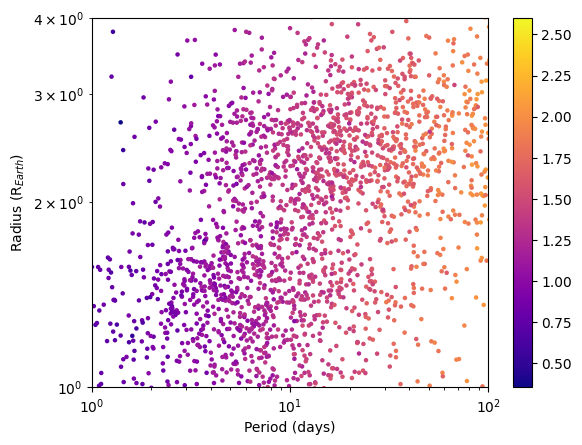

In [31]:
#Look at how planets look with weights
plt.scatter(p_pl_valley, r_pl_valley, c=np.log10(weights_valley), cmap = 'plasma', s=5)
plt.colorbar()
plt.xlabel('Period (days)')
plt.ylabel('Radius (R$_{Earth}$)')
plt.xlim(1, 100)
plt.ylim(1, 4)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [23]:
#Make new planets array

planets = np.array([p_pl_valley, r_pl_valley])
print(planets.shape)

(2, 2694)


In [24]:
# Example data (replace with your bimodal dataset)
log_period = np.log10(p_pl_valley)  # Log-transformed orbital period
log_radius = np.log10(r_pl_valley)  # Log-transformed planet radius
log_planets = np.vstack([log_period, log_radius]).T  # Shape (N, 2)

In [33]:
# Given bandwidths from the paper
bw_x = 0.2  # Bandwidth for log_period
bw_y = 0.04  # Bandwidth for log_radius

# Normalize the data using given bandwidths
scaling_factors = np.array([bw_x, bw_y])
scaled_log_planets = log_planets / scaling_factors

# Fit KDE in the transformed space
kde = KernelDensity(kernel="gaussian", bandwidth=1.0)  # Bandwidth = 1 after scaling
kde.fit(scaled_log_planets, sample_weight=weights_valley)

# Create evaluation grid
log_x_grid, log_y_grid = np.mgrid[np.log10(1):np.log10(100):100j, np.log10(1):np.log10(4):100j]
log_positions = np.vstack([log_x_grid.ravel(), log_y_grid.ravel()]).T

# Normalize grid points using the same scaling
scaled_log_positions = log_positions / scaling_factors

# Evaluate KDE in transformed space
log_z_values = np.exp(kde.score_samples(scaled_log_positions)).reshape(log_x_grid.shape)

# Convert grid back to linear space for plotting
x_grid = 10**log_x_grid
y_grid = 10**log_y_grid


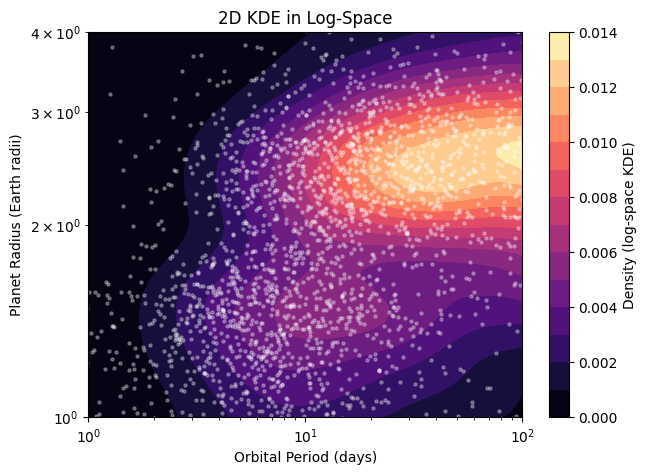

In [34]:
# Plot Log-Space KDE
plt.figure(figsize=(7,5))
plt.contourf(x_grid, y_grid, log_z_values, levels=15, cmap="magma")
plt.colorbar(label="Density (log-space KDE)")
plt.scatter(p_pl, r_pl, s=5, color="white", alpha=0.3)  # Overlay scatter plot
plt.xscale("log")
plt.yscale("log")
plt.xlim(1, 100)
plt.ylim(1, 4)
plt.xlabel("Orbital Period (days)")
plt.ylabel("Planet Radius (Earth radii)")
plt.title("2D KDE in Log-Space")
plt.show()

### Seperate by Mass 

In [158]:
# Pick planets in valley
M_star_valley = M_star[in_valley]
# Define mass bins

bin1 = (M_star_valley >= 0.5) & (M_star_valley < 0.8)
bin2 = (M_star_valley >= 0.8) & (M_star_valley < 0.9)
bin3 = (M_star_valley >= 0.9) & (M_star_valley < 1.0)
bin4 = (M_star_valley >= 1.0) & (M_star_valley < 1.4)

bin_array = [bin1, bin2, bin3, bin4]

Mbins = [0.5, 0.8, 0.9, 1.0, 1.4]

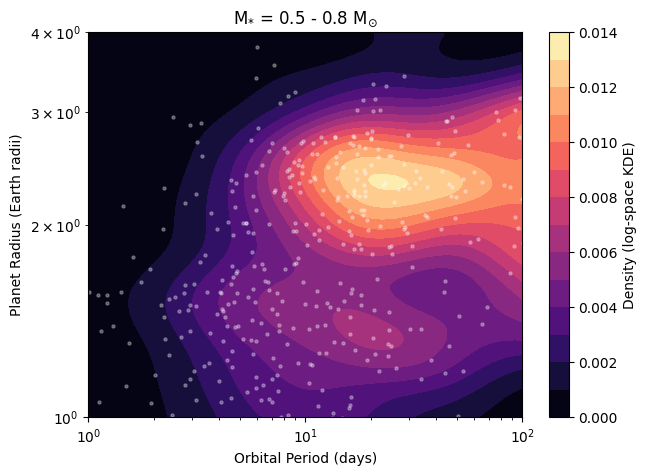

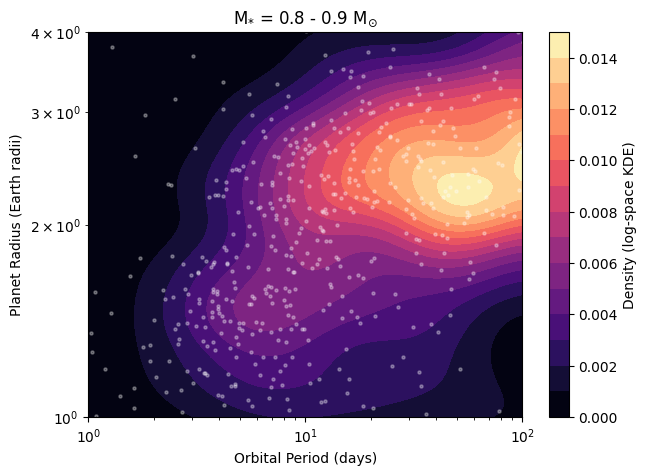

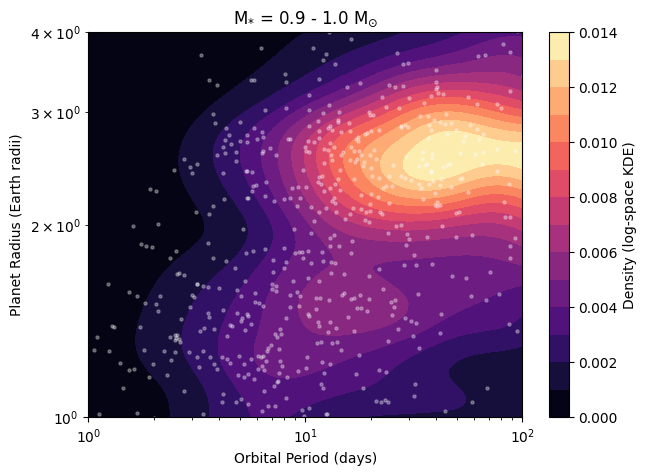

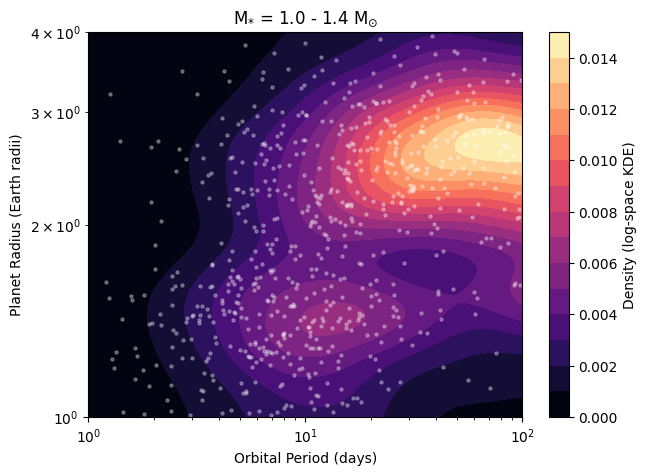

In [159]:
for i in range(len(bin_array)):
    ibin = bin_array[i]

    log_period_bin = log_period[ibin]
    log_radius_bin = log_radius[ibin]  # Log-transformed planet radius
    log_planets_bin = np.vstack([log_period_bin, log_radius_bin]).T  # Shape (N, 2)
    weights_bin = weights_valley[ibin]

    # Fit KDE in the transformed space
    
    # Given bandwidths from the paper
    bw_x = 0.2  # Bandwidth for log_period
    bw_y = 0.04  # Bandwidth for log_radius

    # Normalize the data using given bandwidths
    scaling_factors = np.array([bw_x, bw_y])
    scaled_log_planets = log_planets_bin / scaling_factors

    # Fit KDE in the transformed space
    kde = KernelDensity(kernel="gaussian", bandwidth=1.0)  # Bandwidth = 1 after scaling
    kde.fit(scaled_log_planets, sample_weight=weights_bin)

    # Create evaluation grid
    log_x_grid, log_y_grid = np.mgrid[np.log10(1):np.log10(100):100j, np.log10(1):np.log10(4):100j]
    log_positions = np.vstack([log_x_grid.ravel(), log_y_grid.ravel()]).T

    # Normalize grid points using the same scaling
    scaled_log_positions = log_positions / scaling_factors

    # Evaluate KDE in transformed space
    log_z_values = np.exp(kde.score_samples(scaled_log_positions)).reshape(log_x_grid.shape)

    # Convert grid back to linear space for plotting
    x_grid = 10**log_x_grid
    y_grid = 10**log_y_grid

    # Plot Log-Space KDE
    plt.figure(figsize=(7,5))
    plt.contourf(x_grid, y_grid, log_z_values, levels=15, cmap="magma")
    plt.colorbar(label="Density (log-space KDE)")
    plt.scatter(10**log_period_bin, 10**log_radius_bin, s=5, color="white", alpha=0.3)  # Overlay scatter plot
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1, 100)
    plt.ylim(1, 4)
    plt.xlabel("Orbital Period (days)")
    plt.ylabel("Planet Radius (Earth radii)")
    plt.title(f"M$_{{*}}$ = {Mbins[i]} - {Mbins[i+1]} M$_{{\odot}}$")
    plt.show()
    

